In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import math

%matplotlib inline

imgFile = '../face.jpg'

# Original image

image size:  (1024, 1024, 3)


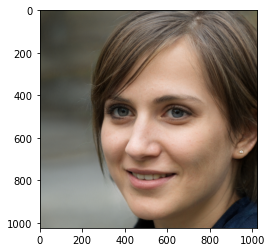

In [6]:
plt.figure()
img = cv2.imread(imgFile)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print('image size: ',img.shape)

# Down sampling 

In [ ]:
# Down sampling 
# https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gaf9bba239dfca11654cb7f50f889fc2ff
plt.figure()
dst = cv2.pyrDown(img)
plt.imshow(dst)
print('image size: ',dst.shape)

In [ ]:
plt.figure()
pyramid = []
dst = img 
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,8), dpi=80, sharex=True, sharey=True)
pyramid.append(dst)
for i in range(0,3):
    dst = cv2.pyrDown(dst)
    pyramid.append(dst)

for i in range(len(pyramid)-1, -1, -1):
    print('image size: ',pyramid[len(pyramid)-1-i].shape)
    ax[i].imshow(pyramid[i])

# Up sampling 

In [ ]:
# Up sampling 
plt.figure()
dst = cv2.pyrUp(img)
plt.imshow(dst)
print('image size: ',dst.shape)

In [ ]:
#Up sampling
plt.figure()
dst = pyramid[3]
pyramid = [] 
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,8), dpi=80, sharex=True, sharey=True)
pyramid.append(dst)
for i in range(0,3):
    dst = cv2.pyrUp(dst)
    pyramid.append(dst)

for i in range(len(pyramid)):
    print('image size: ',pyramid[i].shape)
    ax[i].imshow(pyramid[i])

# Gaussian with intermediate scale

## Gaussian smoothing (example in gray image)

In [ ]:
#ref : http://www.adeveloperdiary.com/data-science/computer-vision/applying-gaussian-smoothing-to-an-image-using-python-from-scratch/
#create a guassian kernel/Filter
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

def gaussian_kernel(size, sigma=2, verbose=False):
 
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    #Compute the outer product of two vectors.
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
    
    #Normalize 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.figure()
        plt.imshow(kernel_2D, interpolation='none',cmap='gray')
        plt.title("Image")
        plt.show()
 
    return kernel_2D
#print(gaussian_kernel(5, sigma=2, verbose=True))

#Perform Convolution and average
def convolution(image, kernel, average=False, verbose=False):
    if len(image.shape) == 3:
        print("Found 3 Channels : {}".format(image.shape))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        print("Converted to Gray Channel. Size : {}".format(image.shape))
    else:
        print("Image Shape : {}".format(image.shape))
 
    print("Kernel Shape : {}".format(kernel.shape))
 
    if verbose:
        plt.figure()
        plt.imshow(image, cmap='gray')
        plt.title("Image")
        plt.show()
 
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
 
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
    if verbose:
        plt.figure()
        plt.imshow(padded_image, cmap='gray')
        plt.title("Padded Image")
        plt.show()
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
            if average:
                output[row, col] /= kernel.shape[0] * kernel.shape[1]
 
    print("Output Image size : {}".format(output.shape))
 
    if verbose:
        plt.figure()
        plt.imshow(output, cmap='gray')
        plt.title("Output Image using {}X{} Kernel".format(kernel_row, kernel_col))
        plt.show()
 
    return output
   
#Gussian smoothing
def gaussian_blur(image, kernel_size, verbose=False):
    kernel = gaussian_kernel(kernel_size, sigma=2, verbose=verbose)
    return convolution(image, kernel, average=True, verbose=verbose)


image = cv2.imread(imgFile)

gaussian_blur(image, 13, verbose=True)


## Method 1 using imutils library 

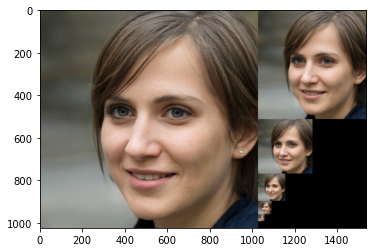

In [18]:
def pyramid_single(image, scale=30):
    # compute the new dimensions of the image and resize it
    w = int(image.shape[1] / scale)
    #Gaussian smoothing 
    image = cv2.GaussianBlur(image,(13,13),2)
    #down sampling
    image = imutils.resize(image, width=w)
    return image

def pyramid(image, scale=1.5, minSize=(30, 30)):
    # yield the original image
    yield image/255
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        #Gaussian smoothing ref: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
        image = cv2.GaussianBlur(image,(13,13),2)
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image/255   #Clipping input data to the valid range for imshow with RGB data [0..1]


pyramid = tuple(pyramid(img, scale=2))   

rows, cols, dim = img.shape

composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)

composite_image[:rows, :cols, :] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

## Method 2 using scikit-image library

In [ ]:
from skimage import transform


rows, cols, dim = img.shape
pyramid = tuple(transform.pyramid_gaussian(img, downscale=2,sigma=2, multichannel=True))

composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)

composite_image[:rows, :cols, :] = pyramid[0]

i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

# Lapacian Pyramid

In [ ]:
#imgFile = '../2003/01/01/big/img_458.jpg'
 
# load an original image
#img = cv2.imread(imgFile)
################################################################################
 
# color value range
cRange = 256
 
# convert color space from bgr to gray
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
################################################################################
 
# pyramid level
level = 4
 
# original image at the bottom of gaussian pyramid
higherResoGauss = img
plt.subplot(2,1 + level,1), plt.imshow(higherResoGauss), plt.title('Gau Lvl 0'), plt.xticks([]), plt.yticks([])
 
for l in range(level):
    
    rows,cols,channels = higherResoGauss.shape
    
    # delete last odd row of gaussian image
    if rows % 2 == 1:
        higherResoGauss = higherResoGauss[:rows - 1,:]
    # delete last odd column of gaussian image                
    if cols % 2 == 1:
        higherResoGauss = higherResoGauss[:,:cols - 1]
             
    # gaussian image
    lowerResoGauss = cv2.pyrDown(higherResoGauss)    
    # even rows and cols in up-sampled image
    temp = cv2.pyrUp(lowerResoGauss)    
    print (higherResoGauss.shape,temp.shape)
    
    # laplacian image
    lowerResoLap = higherResoGauss - temp   
    
    # display gaussian and laplacian pyramid
    plt.subplot(2,1 + level,l + 2), plt.imshow(lowerResoGauss), plt.title('Gau Lvl ' + '%d' % (l+1)), plt.xticks([]), plt.yticks([])
    plt.subplot(2,1 + level,1 + level + l + 2), plt.imshow(lowerResoLap), plt.title('Lap Lvl ' + '%d' % (l)), plt.xticks([]), plt.yticks([])    
 
    higherResoGauss = lowerResoGauss
################################################################################
               
# display original image and gray image
plt.show()

# Scale invariant half-octave pyramid algorithm

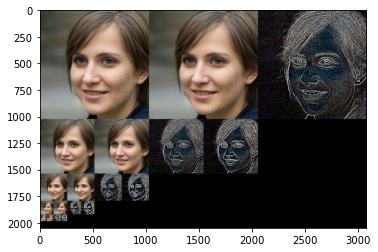

In [80]:
def gaussian(image, scale=2):
    kernel_size = math.floor((scale * 6 + 1))   
    #Gaussian smoothing 
    image = cv2.GaussianBlur(image,(kernel_size,kernel_size), scale)
    return image

def pyramid(image, scale1=1, scale2= 1.414, minSize=(50, 50)):
    image = gaussian(image, scale=scale1)
    yield image 

    level = 0
    while True:
        image = gaussian(image, scale1)
        yield image
        image = gaussian(image, scale2)
        h, w = int(image.shape[0] / 2), int(image.shape[1] / 2)
        image = cv2.resize(image, (w,h), interpolation = cv2.INTER_NEAREST)
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        level += 1
        yield image

pyramid = tuple(pyramid(img, scale1=1, scale2=1.414))   

# plot the composite image
rows, cols, dim = img.shape
composite_image = np.zeros((rows*2, cols * 3, 3), dtype=np.double)

i_rows, i_cols = 0, 0
half_octave = 0
for p in pyramid[:]:
    n_rows, n_cols = p.shape[:2]
    if half_octave % 2 == 0:
        composite_image[i_rows:i_rows + n_rows, i_cols:i_cols + n_cols] = p
        i_cols += n_cols
    else:
        composite_image[i_rows:i_rows + n_rows, i_cols:i_cols + n_cols] = p
        i_rows += n_rows
        i_cols = 0
    half_octave = (half_octave + 1) % 2
#plot the lapacian pyaramid on the composite image 
lapacian_pyramid = []
for i in range(len(pyramid)-1):
    if pyramid[i].shape[0] == pyramid[i+1].shape[0]:
        res = pyramid[i] - pyramid[i+1]
        lapacian_pyramid.append(res)
    else:
        resized_image = cv2.resize(pyramid[i], pyramid[i+1].shape[:2], interpolation = cv2.INTER_NEAREST)
        lapacian_pyramid.append(resized_image - pyramid[i+1])

n_rows, n_cols = lapacian_pyramid[0].shape[:2]
composite_image[:n_rows, 2 * n_cols : 3 * n_cols] = lapacian_pyramid[0]
i_rows = n_rows

for i in range(1,len(lapacian_pyramid)):
    n_rows, n_cols = lapacian_pyramid[i].shape[:2]
    if i % 2 == 1:
        composite_image[i_rows:i_rows + n_rows, 2 * n_cols: 3 * n_cols] = lapacian_pyramid[i]
    else:
        composite_image[i_rows:i_rows + n_rows, 3 * n_cols: 4 * n_cols] = lapacian_pyramid[i]
        i_rows += n_rows
    
fig, ax = plt.subplots()
ax.imshow(composite_image.astype(int))
plt.show()

